In [1]:
# Importanto bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
# Carregando datasets para iniciar análise exploratória dos dados.
dataset_train = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv') 
gender_submission = pd.read_csv('gender_submission.csv')

In [3]:
dataset_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Nitidamente existem algumas variáveis que são irrelevantes para o modelo tais como: Name, Ticket, Fare, Cabin Embarked pois:

# Name = O nome de cada tripulante e passageiro já está atrelado à variável PassengerId. Não precisamos de informações duplicadas
# Ticket = O número da passagem não importa para predizer sobreviventes, não existe uma relação com a variável Target
# Fare = A tarifa paga pelo passageiro não implica em causalidade da variável target
# Cabin = O número da cabine também não implica eu causalidade da sobrevivência do passageiro
# Embarked = A porta de embarque do passageiro também nitidamente não determina a sobrevivência visto que este é um fato que ocorreu antes mesmo do navio iniciar a viagem

# Portanto estas variáveis podem ser eliminadas dos datasets de treino e teste

# Eliminando as variáveis preditoras sem relevância para o modelo dataset_train
dataset_train = dataset_train.drop(columns=['Name','Ticket','Fare','Cabin','Embarked','PassengerId'], axis=1) 

# Eliminando as variáveis preditoras sem relevância para o modelo dataset_test
dataset_test = dataset_test.drop(columns=['Name','Ticket','Fare','Cabin','Embarked','PassengerId'], axis=1)  

In [6]:
# Verificando as informações das variáveis que compõe o dataset_train
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 41.9+ KB


In [7]:
# Verificando as informações das variáveis que compõe o dataset_test
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    object 
 2   Age     332 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 16.5+ KB


In [8]:
# Verificando a existência de arquivos de registros nulos no dataset_train
dataset_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
dtype: int64

In [9]:
# Verificando a existência de arquivos de registros nulos no dataset_test
dataset_test.isnull().sum()

Pclass     0
Sex        0
Age       86
SibSp      0
Parch      0
dtype: int64

In [10]:
# Observe que ambos os datasets apresentam valores nulos na variável / coluna idade. Estas valores nulos serão preenchidos com a média das idades.

# Preenchendo valores nulos na variável Age no dataset_train com a média das idades
dataset_train = dataset_train.fillna(dataset_train.Age.mean())

In [11]:
# Preenchendo valores nulos na variável Age no dataset_test com a média das idades
dataset_test = dataset_test.fillna(dataset_test.Age.mean())

In [12]:
dataset_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
dtype: int64

In [13]:
dataset_test.isnull().sum() 

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
dtype: int64

In [14]:
# Existe uma variável que ainda necessita ser transformada em ambos os datasets: A variável Sex (categórica)

# Transformando a variável Sex numa variável categórica numérica:
dataset_train.Sex = dataset_train.Sex.map({'female':0,'male': 1})
dataset_test.Sex = dataset_test.Sex.map({'female':0,'male': 1})

In [15]:
dataset_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,0,38.0,1,0
2,1,3,0,26.0,0,0
3,1,1,0,35.0,1,0
4,0,3,1,35.0,0,0


In [16]:
dataset_test.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,34.5,0,0
1,3,0,47.0,1,0
2,2,1,62.0,0,0
3,3,1,27.0,0,0
4,3,0,22.0,1,1


In [17]:
# Verificando se a variável target possui as classes balanceadas
dataset_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

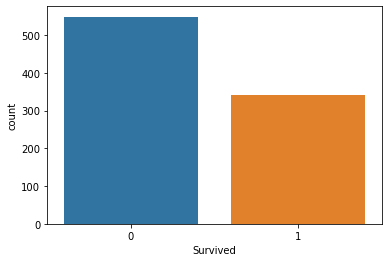

In [18]:
# Verificando graficamente o desbalanceamento
sb.countplot(x=dataset_train.Survived, data=dataset_train)

In [19]:
# Dividindo o dataset_train em dois datasets x (variáveis preditoras) e y (variável target)
x = dataset_train.drop(columns='Survived')
y = dataset_train.Survived

In [20]:
# Verificando o shape dos datasets criados 
x.shape , y.shape

((891, 5), (891,))

In [21]:
# Aplicando o algoritmo SMOTE para balancear as classes da variável target

# Instanciando o algoritmo
smt = SMOTE()

In [22]:
# Equalizando as classes da variável target
x, y = smt.fit_sample(x,y)

In [23]:
# Verificando a equalização das classes da variável target após a aplicação do SMOTE
y.value_counts()

1    549
0    549
Name: Survived, dtype: int64

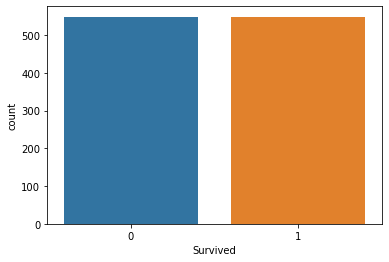

In [24]:
# Graficamente
sb.countplot(x=y, data=dataset_train)

In [30]:
# Criando um GridSearch para testar parâmetros do algoritmo SVM

# Criando uma lista de valores para o parâmetro C
c_parameter = range(1,5,1)

# Criando uma lista de valores para o parâmetro kernel
kernel_parameter = ['linear','poly','rbf','sigmoid'] 
                    
# Criando uma lista de valores para o parâmetro gamma
gamma_parameter = ['scale','auto'] 

In [31]:
# Instanciando os parâmetros GridSearch
grid_parameters = dict(C=c_parameter, kernel=kernel_parameter, gamma=gamma_parameter)

In [32]:
# Instanciando o classificador
model_svm = svm.SVC()

In [33]:
# Executando o GridSearch e passando os parâmetros 
grid = GridSearchCV(model_svm, grid_parameters)

In [34]:
# Treinando o algoritmo
grid.fit(x,y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': range(1, 5), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [35]:
# Verificando o melhor score 
grid.best_score_

0.8252054794520548

In [36]:
# Visualizando os melhores parâmetros
grid.best_params_

{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}

In [41]:
# Instanciando o modelo com os melhores parâmetros
svm_model = svm.SVC(C=3, gamma='auto', kernel='rbf')

In [42]:
# Treinando o modelo com os melhores parâmetros
svm_model.fit(x,y)

SVC(C=3, gamma='auto')

In [43]:
predicted = svm_model.predict(dataset_test)

In [44]:
predicted.shape

(418,)

In [46]:
score_model_svm = round(svm_model.score(x,y)*100,2)

In [47]:
print(score_model_svm)

87.52


In [48]:
# Criando o arquivo para envio ao Kaggle
submission = pd.DataFrame({'PassengerId': gender_submission['PassengerId'],'Survived': predicted})

In [49]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [50]:
# Salvando o arquivo em disco
submission.to_csv('submission.csv', index=False)